**To-do:** Extract scripts from notebook and adapt to iterate over system size. Currently the notebook must be run for each system size individually and at the bottom of the notebook 'Z-Zpeak_vs_T' files for each system size are plotted together manually.


# Analysis of 1st Zn-Zn PCF peak
This script allows us to investigate the difference in the PCF peak intensity of nearest-neighbour Zn-to-Zn ions.

We use this as an order parameter because disorder in the Cu-Zn planes results in the emergence of a new nearest-neighbour Zn-Zn peak due to the clustering of Zn ions, when compared to a reference ordered CZTS lattice. 

## Eris simulation flags
By default Eris will output initial and final PCFs (called RDF's by Eris) for all pairs of species. To output an RDF after each MCMegaStep (as used in this script) you must set the **'CalculateRadialOrderParameter'** flag to true. Ensure that MCMegaSteps is several multiples of MCEqmSteps to allow for lots of independent data to analyse.


## User defined inputs
The first two code cells contain the only calculation parameters that need to be inputted into the script by the user and they will be reused throughout the notebook. First add the temperature range and MCSteps requested in the top bash script, then add in the details requested for python script inputs directly below that (including system dimensions). 

**Make sure to run each cell!**

## 1. Sort raw outputs from Eris
As for other RDF scripts, if this is the first time plotting this RDF data, it may be necessary to run this bash script to comment out the first data line in the RDF files (which corresponds to the RDF of a species with itself, giving r=0 and an infinite 1/r!). It doesn't matter if this has been run before, you'll just end up with multiple '#'s in your commented out line - better safe than sorry!

In [4]:
%%bash

### USER INPUTS
# Setting the temperature range (as defined in cx1 submission script)
TMAX=1000
TMIN=0
TSTEP=50
# Setting MCSteps (as defined in eris.cfg)
MCEqmSteps=50
MCMegaSteps=500
# ---------------------------------------------------------------------
# No edits below here needed

# Define step size so that we analyse outputs in increments of MCEqmSteps (data should be de-coupled)
StepSize=$(bc <<< "${MCEqmSteps}/10" )

### REMOVED BELOW STEP DUE TO TOO MANY FILES! - '-bash: /bin/mv: Argument list too long'
# Moving data to a separate directory (if not done already)
#if [ ! -d "RDF_data" ]; then
#  mkdir RDF_data
#  mv RDF* RDF_data
#fi

# Looping over files we want to analyse, comment out first line (infinite PCF of species with itself)
for temp in $(seq -w $TMIN $TSTEP $TMAX)
do
  for output in $(seq -f "%05g" 1 $StepSize $MCMegaSteps) 
  do
    sed -e '2s/^/#/' RDF_Z_Z_Temp_${temp}_Step_${output}.dat > tmp.dat
    mv tmp.dat RDF_Z_Z_Temp_${temp}_Step_${output}.dat
  done
done

## 2. User inputs for python scripts

In [5]:
# Setting the temperature range (as defined in cx1 submission script)
TMAX=1000
TMIN=0
TSTEP=50

# Setting MCSteps (as defined in eris.cfg)
MCEqmSteps=50
MCMegaSteps=500

# Enter dimensions of system (as defined in eris-config.c)
X_dim = 20
Y_dim = 20
Z_dim = 20
#-------------------------------------------------------------------
# No edits below here needed

# Define step size so that we analyse outputs in increments of MCEqmSteps/10 
# We gather data 10x more regularly than the equilibriation time after our equilibration burn-in
# Define total number of outputs (portion of total MC steps) for each T to analyse
StepSize=MCEqmSteps/10
outputs_tot=(MCMegaSteps/StepSize)

The following sections do not require further user inputs, just run the cells in turn.


## 3. Plotting the first peak intensity as a function of temperature for each system size
Below is a script to create a file of just the first peak of the Zn-Zn PCF for each similation temperature so that we can investigate the peak intensity as a function of temperature-induced Cu-Zn disorder.

Ensure that the temperature range entered above matches that used in the eris simulation.

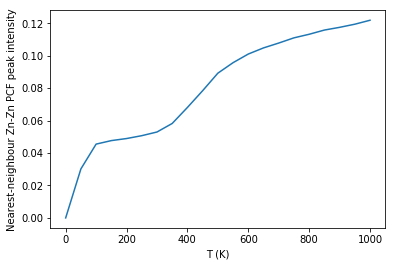

In [6]:
%matplotlib inline
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
#from IPython.core.pylabtools import figsize
#figsize(10, 10)

T_plot = np.arange(TMIN, TMAX+TSTEP, TSTEP)
Z_Z_peak1 = []
Z_Z_peak1_single_run = []
Z_Z_peak1_av = []
data_files = []

# Looping through RDF data files we want to analyse and writing first peak to a file
# Looping over T
for i in range(0, len(T_plot)): # Looping over all T's
    temperature = str(T_plot[i])
    temperature_formatted = str(temperature).zfill(4)
    # Looping over outputs every MCEqmSteps/10 MCMegaStep at each T
    for j in range(1, MCMegaSteps+1, int(StepSize)):
        output_formatted = str(j).zfill(5)
        data_files.append("RDF_Z_Z_Temp_"+str(temperature_formatted)+"_Step_"+str(output_formatted)+".dat")      

for i in range (0,len(data_files)):
    simulation_data= np.genfromtxt(data_files[i], delimiter = ' ')
    # Append first Z-Z peak intensity for all T and multiples runs to the same list
    # Element selected below corresponds to RDF[lattice] for r_sq=2, noting that the first two rows are commented out
    Z_Z_peak1.append(simulation_data[1,2])
    
# Averaging over multiple outputs for each T and also outputting single run for testing purposes
# Step size of outputs_tot to loop over outputs in list for each T
for i in range(0, len(Z_Z_peak1), int(outputs_tot)):
    Z_Z_peak1_single_run.append(Z_Z_peak1[i]) # Taking first value for each T
    Z_Z_peak1_av.append(sum(Z_Z_peak1[i:i+int(outputs_tot-1)])/outputs_tot) # Averaging over all outputs for each T
    
# Writing T's and Q's to a file to plot multiple systems together later
plot_data = pd.DataFrame({'# T' : T_plot, 'Averaged Z-Z 1st peak' : Z_Z_peak1_av})
Z_Z_peak_file='Z-Zpeak_vs_T'+str(X_dim)+'x'+str(Y_dim)+'x'+str(Z_dim)+'.dat'
plot_data.to_csv(Z_Z_peak_file, sep=' ', index=False, header=False)

plt.plot(T_plot, Z_Z_peak1_av)
#plt.plot(T_plot, Z_Z_peak1_single_run)  # For testing purposes, to check that runs were de-coupled (i.e. av not exactly same as single run)
plt.xlabel('T (K)')
plt.ylabel('Nearest-neighbour Zn-Zn PCF peak intensity')
plt.show()


### 4. Plotting for various system sizes
Repeat step 3 for various system sizes (making sure to update the system size in step 2 each time).

Then enter the dimensions for each system size you wish to plot for in the script below. This is currently pretty clunky and repetitive - would be nicer to loop over this!

In [4]:
# Enter dimensions of the systems
# System 1
X2 = 12
Y2 = 12
Z2 = 12
# System 2
X1 = 16
Y1 = 16
Z1 = 16

%matplotlib inline
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.pylabtools import figsize
figsize(12, 10)

file1='Z-Zpeak_vs_T'+str(X1)+'x'+str(Y1)+'x'+str(Z1)+'.dat'
file2='Z-Zpeak_vs_T'+str(X2)+'x'+str(Y2)+'x'+str(Z2)+'.dat'

data1= np.genfromtxt(file1, delimiter = ' ')
data2= np.genfromtxt(file2, delimiter = ' ')

plt.plot(data1[:,0], data1[:,1], label=str(X1)+'x'+str(Y1)+'x'+str(Z1))
plt.plot(data2[:,0], data2[:,1], label=str(X2)+'x'+str(Y2)+'x'+str(Z2))
plt.xlabel('T (K)')
plt.ylabel('Nearest-neighbour Zn-Zn PCF peak intensity')
plt.legend()
plt.show()

OSError: Z-Zpeak_vs_T16x16x16.dat not found.